# Recurrent Neural Networks

We'll introduce the concept of recurrent neural networks, which explicitly model the time-dependency of their inputs to facilitate the analysis of sequential data. We'll demonstrate this functionality using a weather forecasting dataset in a classic time-series analysis approach.


# Implement a Simple Recurrent Neural Network

We start with an example implementing the feed-forward pass of a recurrent neural network in NumPy. To keep things simple, we assume that the signal is a scalar value containing a single feature. 


In [1]:
import numpy as np

def sigmoid(x):
    """Simple implementation of sigmoid function."""
    return 1 / (1 + np.exp(-x))

input_series = [0, 1, 1, 2, 3, 5, 8]
output_series = []

state = 0
U, V, W, b = [np.random.normal() for _ in range(4)]
for t in input_series:
  hidden = sigmoid(np.dot(U, t) + np.dot(V, state) + b)
  output = sigmoid(np.dot(hidden, W))
  state = output
  output_series.append(output)

print(f"Input Series: {[f'{x:.2f}' for x in input_series]}")
print(f"Output Series: {[f'{x:.2f}' for x in output_series]}")

Input Series: ['0.00', '1.00', '1.00', '2.00', '3.00', '5.00', '8.00']
Output Series: ['0.57', '0.60', '0.60', '0.60', '0.61', '0.61', '0.62']


## Load Weather Dataset

We download the uncompressed dataset of the Jena Climate Dataset from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip.

More information on this dataset can be found at https://www.bgc-jena.mpg.de/wetter/.

In [2]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "weather_dataset")
if not os.path.exists(dataset_path):
    url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
    download_url(url, ".")
    _extract_zip("jena_climate_2009_2016.csv.zip", dataset_path, None)
    os.remove("jena_climate_2009_2016.csv.zip")

This dataset contains 14 weather measurements in a `.csv` file. Their meaning is shown in the header.

In [3]:
import csv
    
filename = os.path.join(dataset_path, 'jena_climate_2009_2016.csv')
with open(filename) as f:
    reader = csv.reader(f)
    header = next(reader)
    data = []
    for row in reader:
        data.append(row[1:])  # The first value ('Date Time') is excluded.
    data = np.asarray(data).astype(float)

print(header)

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


## Visualize Data

We now visualize the 14 measured features of the dataset. 

In [4]:
import matplotlib.pyplot as plt

def plot_data(data, start=0, samples_per_cycle=144, cycles=14):
    """Plot data highlighting periodic cycles."""

    fig, axes = plt.subplots(7, 2, figsize=(16, 12), sharex=True)

    for i, ax in enumerate(axes.flatten()):
        ax.plot(np.arange(start, start + samples_per_cycle * cycles),
                data[start:start + samples_per_cycle * cycles, i], 
                label=header[i + 1])
        ax.legend()
        ax.set_xlim(start, start + samples_per_cycle * cycles)
        
        for cycle in range(1, cycles):
            ax.axvline(x=start + cycle * samples_per_cycle, 
                    color='gray', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

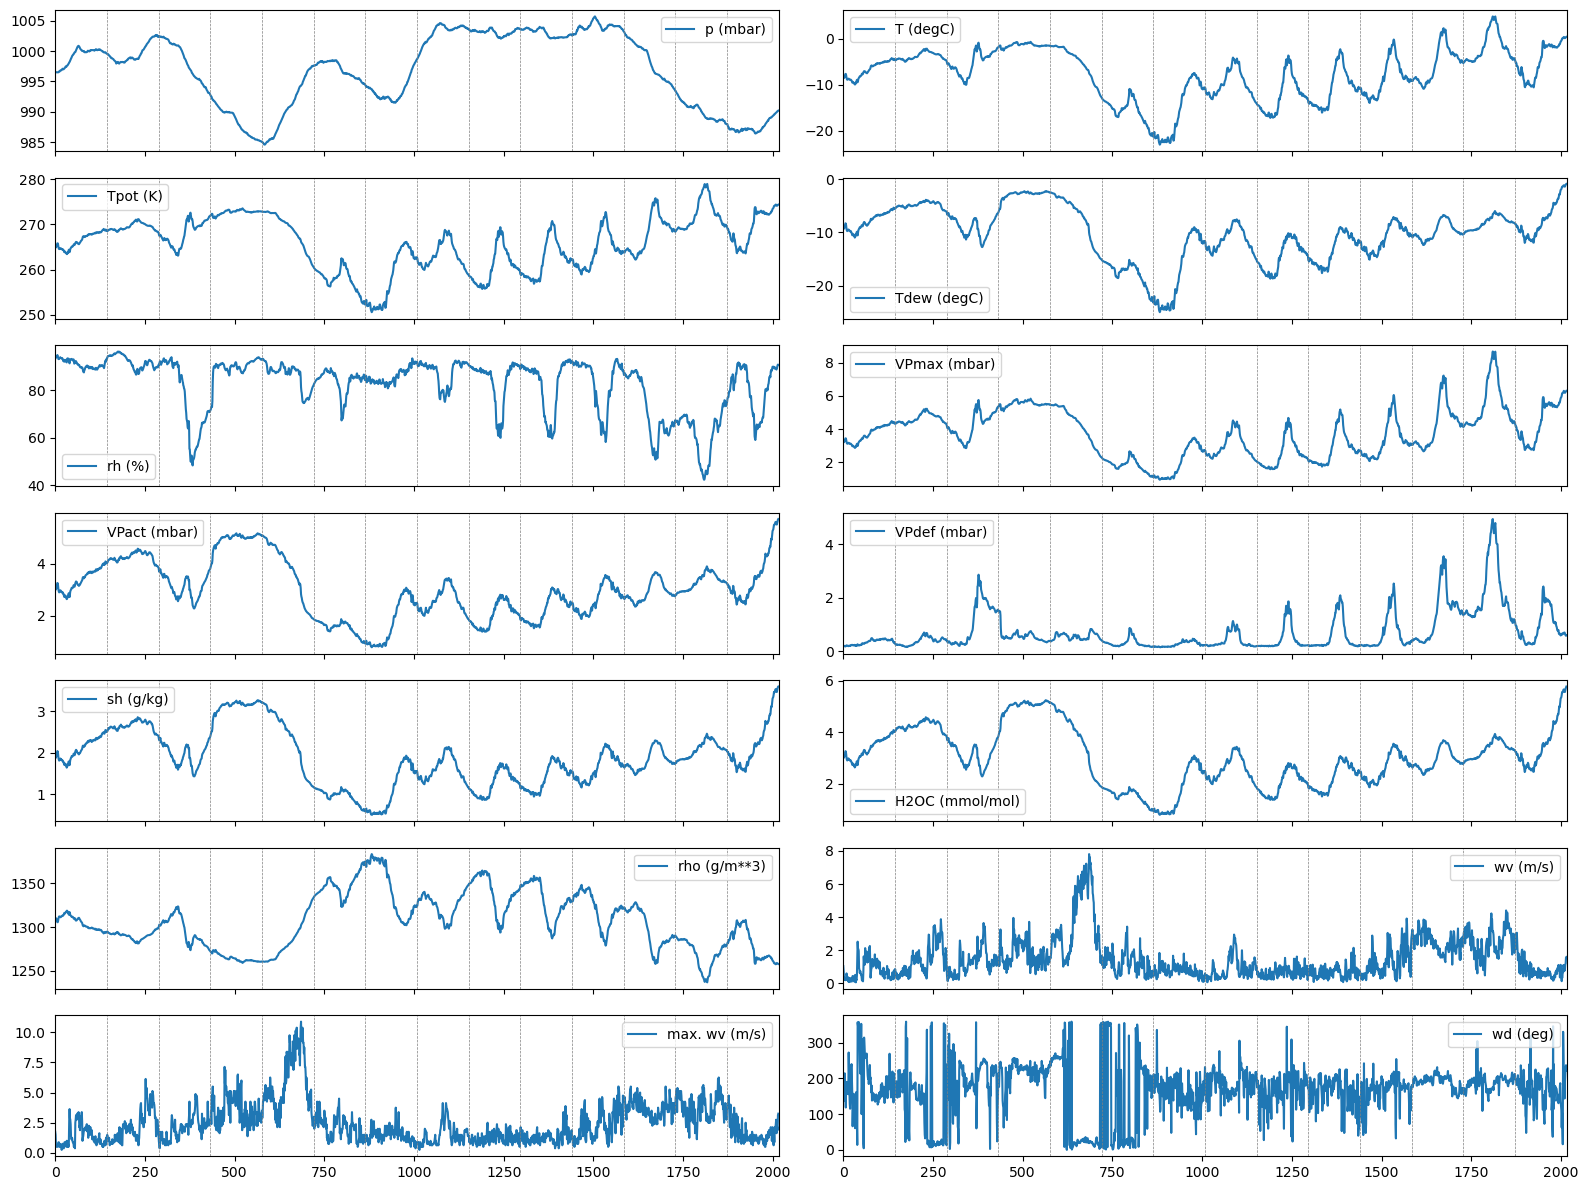

In [5]:
#from fnc_rnn import plot_data

daily_samples=144
n_days = 14

plot_data(data, samples_per_cycle=daily_samples, cycles=n_days)


## Preprocess Data

We start by removing the mean from the data and normalizing them by their standard deviation.

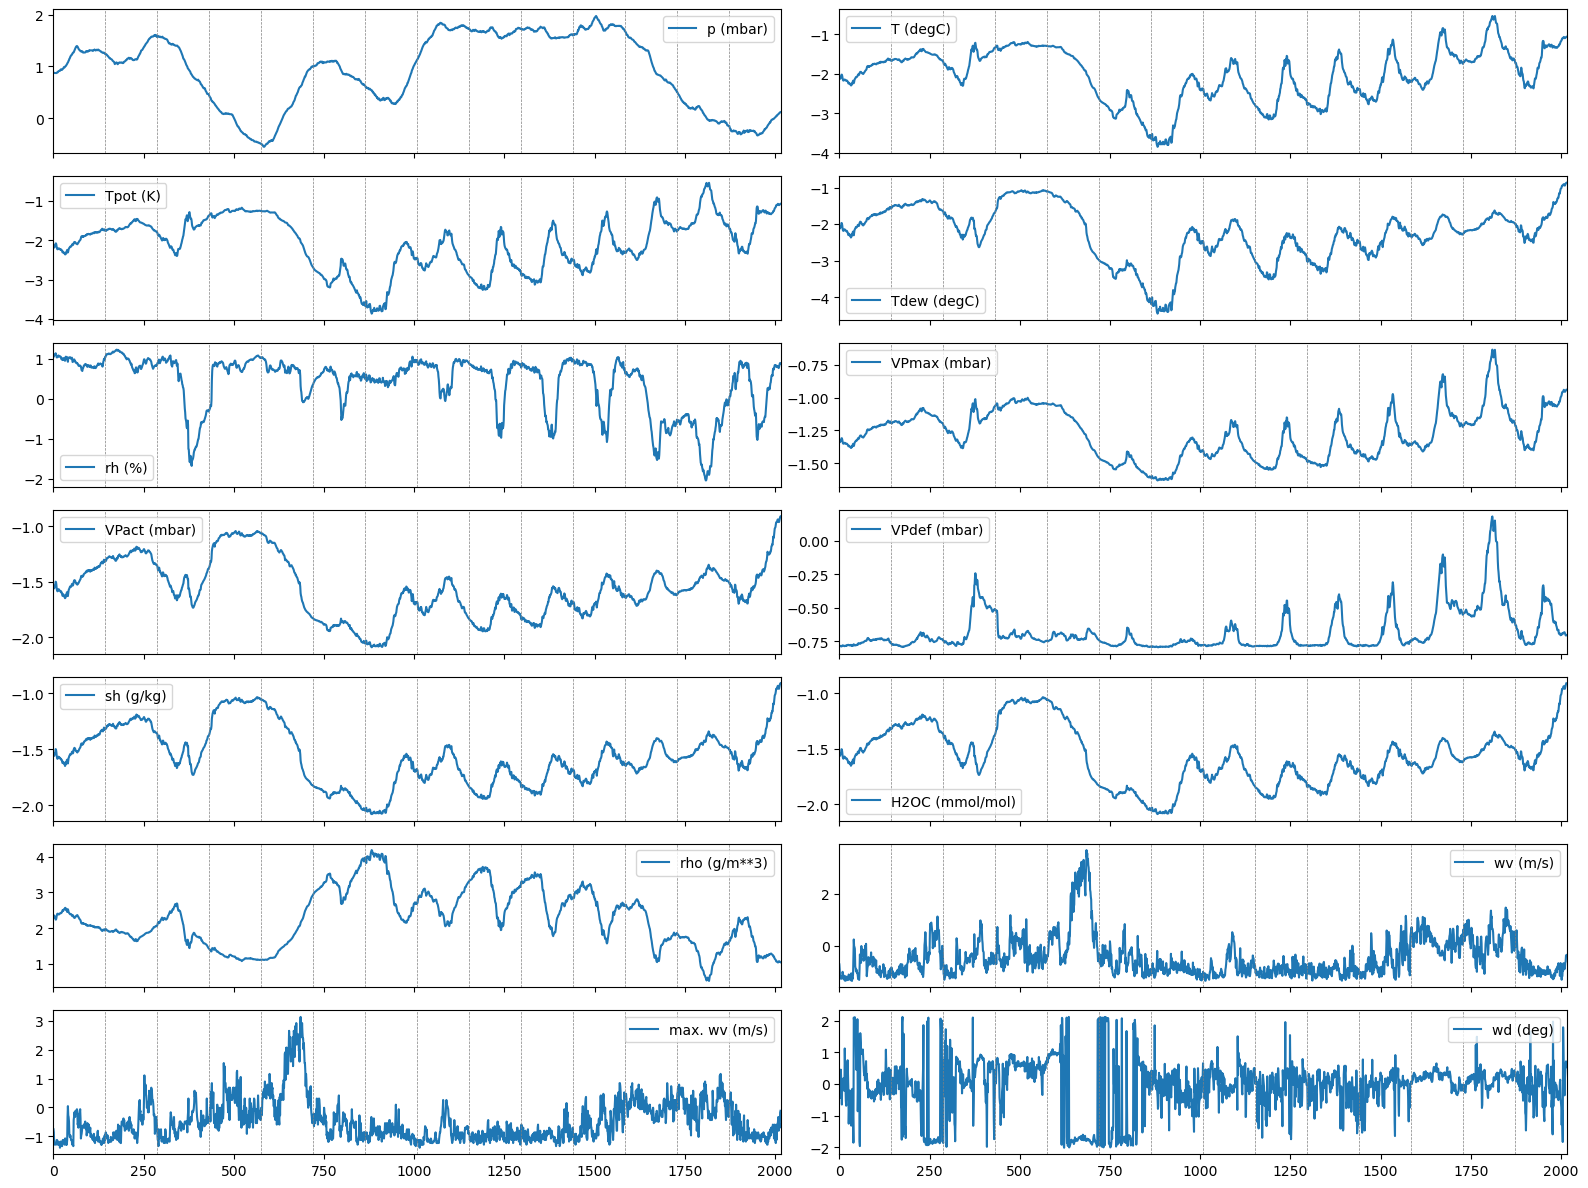

In [6]:
data -= data.mean(axis=0)
data /= data.std(axis=0)

plot_data(data, samples_per_cycle=daily_samples, cycles=n_days)

We now preprocess the data into time series to input into the neural network model, that is, they need to be of shape (batch size, number of samples, number of feature).

In [7]:
n_samples = data.shape[0]
n_features = data.shape[1]
pred_window = 288  # Length of the sequences to be fed to the RNN.
pred_lag = pred_window + 72  # How many time_steps ahead in time the RNN should predict temperature. 1 very easy. 18 used for course. 144 = 1 day

inputs, targets = [], []
for i in range(0, n_samples - pred_lag, pred_window):
    inputs.append(data[i:i + pred_window, :])
    targets.append(data[i + + pred_lag:i + pred_lag + 1, 2])
inputs = np.asarray(inputs)
targets = np.asarray(targets)

print(inputs.shape)
print(targets.shape)


(1459, 288, 14)
(1459, 1)


<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/module-examples/models_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## Implement PyTorch RNN Model

This example introduces the `RNN` module in PyTorch.

In [8]:
import torch
import torch.nn as nn

input_size = inputs.shape[2]
hidden_units = 2

# Define the RNN and Linear layers separately.
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_units, batch_first=True)
fc = nn.Linear(hidden_units, 1)

# Loss and optimizer.
criterion = nn.L1Loss()  # MAE Loss.
optimizer = torch.optim.Adam(list(rnn.parameters()) + list(fc.parameters()), lr=0.001)



Current Training Loss: 1.3440 Current Validation Loss: 1.3174
Current Training Loss: 1.2464 Current Validation Loss: 1.2223
Current Training Loss: 1.1582 Current Validation Loss: 1.1356
Current Training Loss: 1.0761 Current Validation Loss: 1.0551
Current Training Loss: 0.9982 Current Validation Loss: 0.9775
Current Training Loss: 0.9269 Current Validation Loss: 0.9054
Current Training Loss: 0.8624 Current Validation Loss: 0.8379
Current Training Loss: 0.8039 Current Validation Loss: 0.7756
Current Training Loss: 0.7517 Current Validation Loss: 0.7205
Current Training Loss: 0.7082 Current Validation Loss: 0.6771
Current Training Loss: 0.6719 Current Validation Loss: 0.6481
Current Training Loss: 0.6408 Current Validation Loss: 0.6222
Current Training Loss: 0.6129 Current Validation Loss: 0.6003
Current Training Loss: 0.5878 Current Validation Loss: 0.5819
Current Training Loss: 0.5676 Current Validation Loss: 0.5641
Current Training Loss: 0.5506 Current Validation Loss: 0.5474
Current 

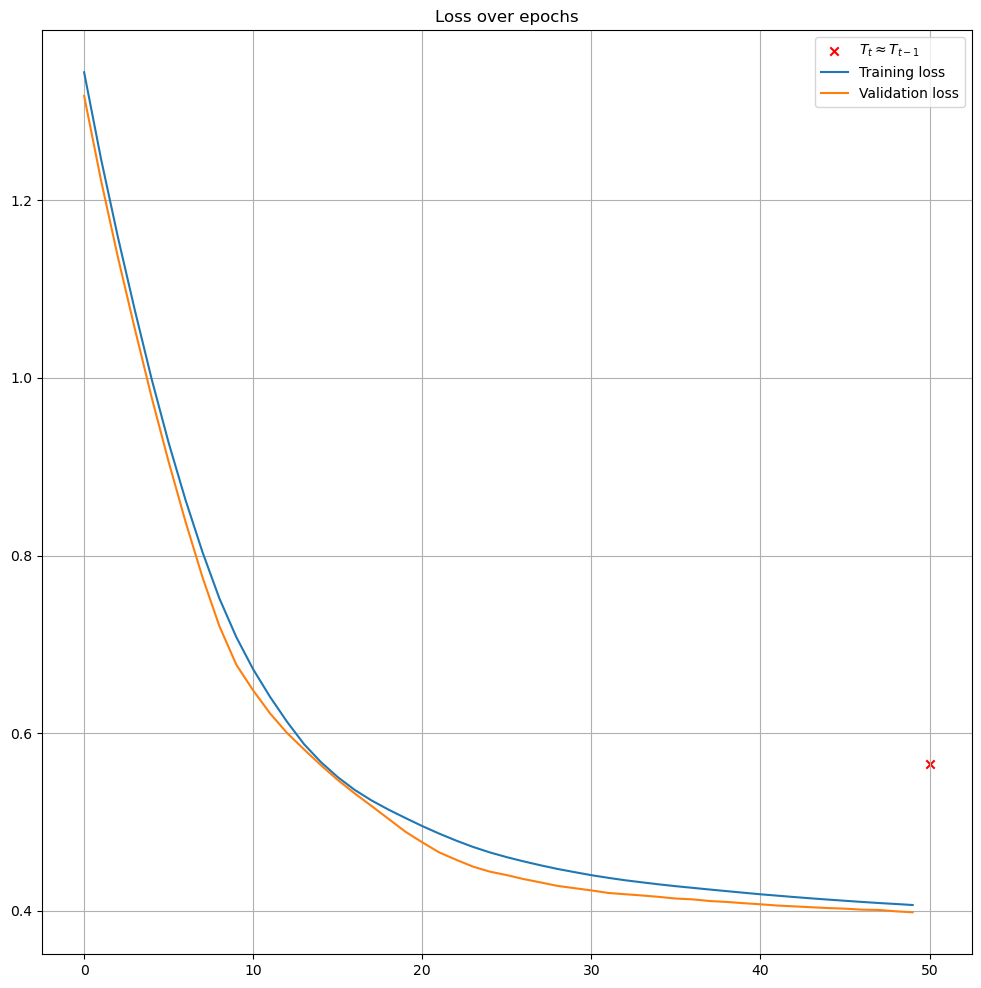

In [10]:
from torch.utils.data import random_split,TensorDataset, DataLoader

def create_data_loader(input_data, target_data, batch_size=32):

    # Convert to PyTorch tensors
    input_tensor = torch.tensor(input_data, dtype=torch.float32)
    target_tensor = torch.tensor(target_data, dtype=torch.float32)

    # Splitting the dataset into training and validation
    train_dataset = TensorDataset(input_tensor[:nr_of_sequences], target_tensor[:nr_of_sequences])
    train_dataset,val_dataset = random_split(train_dataset, [0.8, 0.2])
    # Creating data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

    return train_loader, val_loader

def create_benchmark(val_loader): #generate benchmark for comparison, i.e. predict T_t = T_{t-1}

    mae_benchmark=[]
    for input, target in val_loader:
        val_predict_sequence = input[:, -1, 2]
        val_target_sequence = target[:, 0]
        ae=torch.abs(val_predict_sequence - val_target_sequence)
        mae_benchmark.append(ae)

    mae_benchmark=torch.cat(mae_benchmark)
    mae_benchmark=torch.mean(mae_benchmark)
    return mae_benchmark

def train_model(rnn,fc, nr_of_sequences, epochs, criterion, optimizer,train_loader,val_loader):

    rnn.train()
    fc.train()
    train_losses = []
    val_losses = []

# Training Loop
    for epoch in range(epochs):
        running_loss = 0.0
        for input, target in train_loader:
            optimizer.zero_grad()

            # RNN layer
            rnn_out, _ = rnn(input)
            
            # Selecting the last output for each sequence
            rnn_out = rnn_out[:, -1, :]
            
            # Linear layer
            output = fc(rnn_out)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation loop
        rnn.eval()
        fc.eval()
        val_loss = 0.0
        with torch.no_grad():
            for input, target in val_loader:
                # RNN layer
                rnn_out, _ = rnn(input)
                
                # Selecting the last output for each sequence
                rnn_out = rnn_out[:, -1, :]
                
                # Linear layer
                output = fc(rnn_out)
                loss = criterion(output, target)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print("Current Training Loss: {:.4f}".format(train_losses[-1])+ " Current Validation Loss: {:.4f}".format(val_losses[-1]))

    # Generate predictions on validation set
    with torch.no_grad():
        val_input_tensor = torch.tensor(inputs[nr_of_sequences:], dtype=torch.float32)
        val_rnn_out, _ = rnn(val_input_tensor)
        val_rnn_out = val_rnn_out[:, -1, :]
        val_predict_sequence = fc(val_rnn_out).numpy()
        val_target_sequence = target[nr_of_sequences:]
    return train_losses, val_losses,val_predict_sequence,val_target_sequence

import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses,mae_benchmark):
    plt.figure(figsize=(12, 12))
    plt.scatter(len(train_losses),mae_benchmark,marker='x',c='red', label=r"$T_t \approx T_{t-1}$")
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.legend(loc="best")
    plt.title("Loss over epochs")
    plt.grid(True)
    plt.show()

def train_and_plot(rnn,fc, nr_of_sequences, epochs,criterion, optimizer,train_loader,val_loader):
    train_losses, val_losses,val_predict_sequence,val_target_sequence = train_model(rnn,fc, nr_of_sequences,epochs,criterion,optimizer,train_loader, val_loader)
    plot_losses(train_losses, val_losses,mae_benchmark)
    return val_predict_sequence,val_target_sequence


nr_of_sequences=1600
epochs=50
train_loader, val_loader = create_data_loader(inputs, targets)
mae_benchmark=create_benchmark(val_loader)
val_predict_sequence,val_target_sequence = train_and_plot(rnn,fc,nr_of_sequences,epochs,criterion,optimizer,train_loader, val_loader)

## Implement the RNN in Deeplay

We now implement the RNN in deeplay.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(14, 2, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=2, out_features=1, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout

2023-12-23 09:55:54.315466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 39    
5 | optimizer     | Adam             | 0     
---------------------------------------------------
39        Trainable params
0         Non-trainable params
39        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


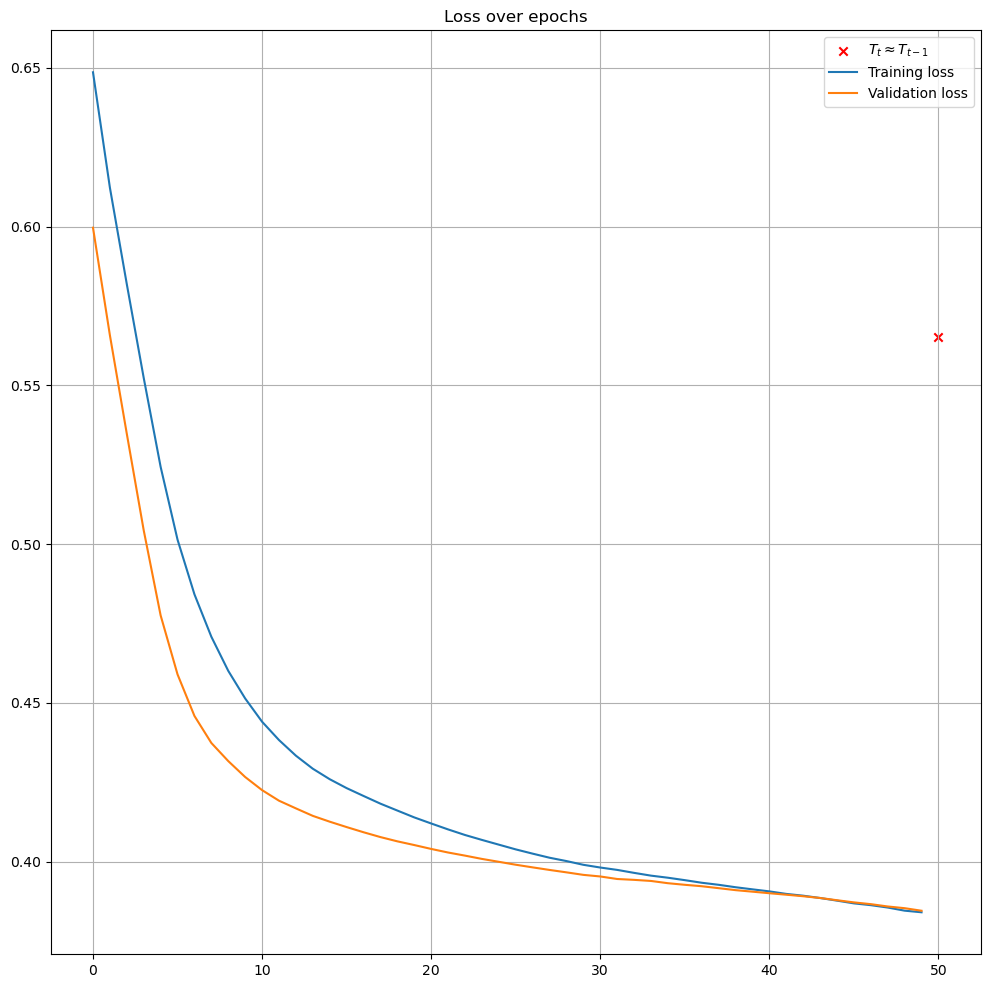

In [11]:
import deeplay as dl

rnn = dl.RNN(in_features=14,hidden_features=[hidden_units],out_features=1,rnn_type="RNN")
model = dl.Regressor(rnn,optimizer=dl.Adam(lr=0.001))
model=model.create()
print(model)

from lightning.pytorch.callbacks import Callback
class LossHistory(Callback):
    def on_train_start(self, trainer, pl_module):
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        val_loss = trainer.callback_metrics.get('val_loss')
        if train_loss is not None:
            self.val_losses.append(val_loss.item())

loss_history = LossHistory()
trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

### Stacked RNN

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 7.9 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(14, 32, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1-3): 3 x RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(32, 32, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (4): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_fe

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


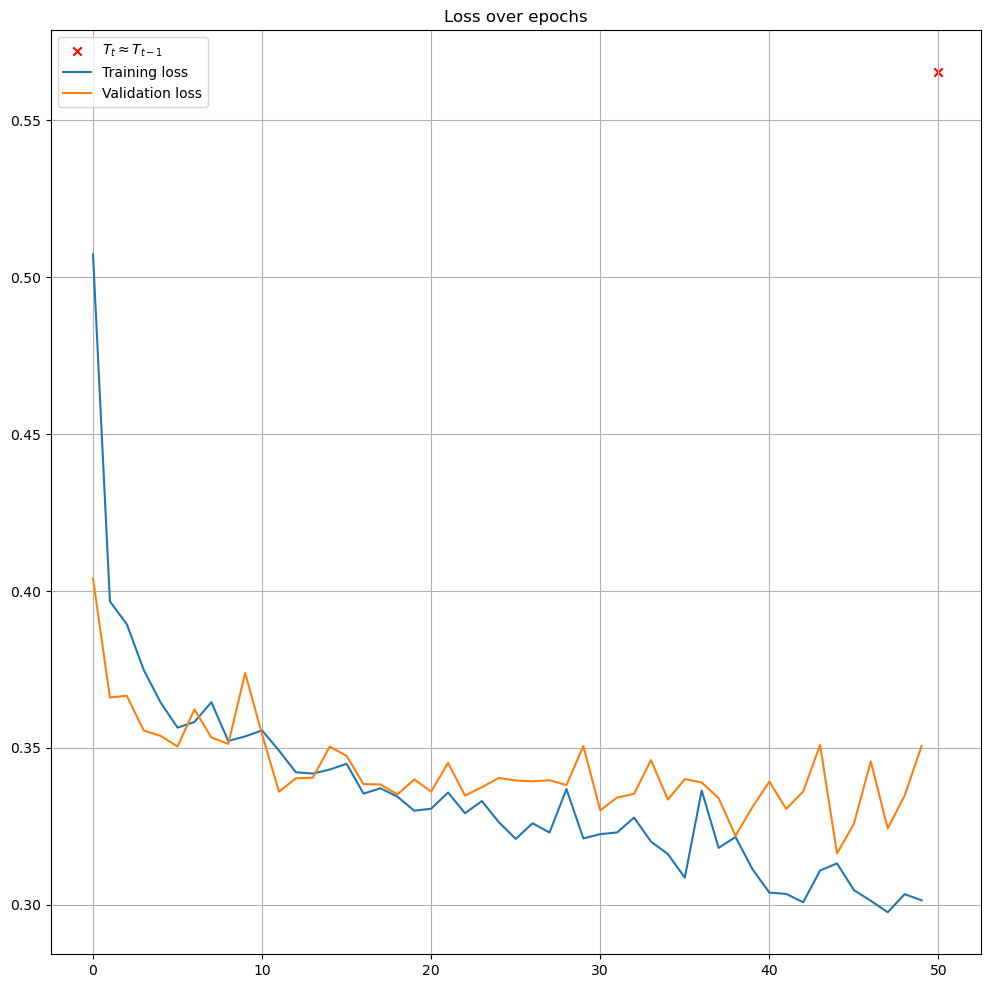

In [12]:

hidden_features=[32,32,32,32]
rnn = dl.RNN(in_features=14,hidden_features=hidden_features,out_features=1,rnn_type="RNN")
model = dl.Regressor(rnn,optimizer=dl.Adam(lr=0.001))
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)
plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)


### Stacked GRU

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 23.6 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
23.6 K    Trainable params
0         Non-trainable params
23.6 K    Total params
0.095     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): GRU(14, 32, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1-3): 3 x RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): GRU(32, 32, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (4): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_fe

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


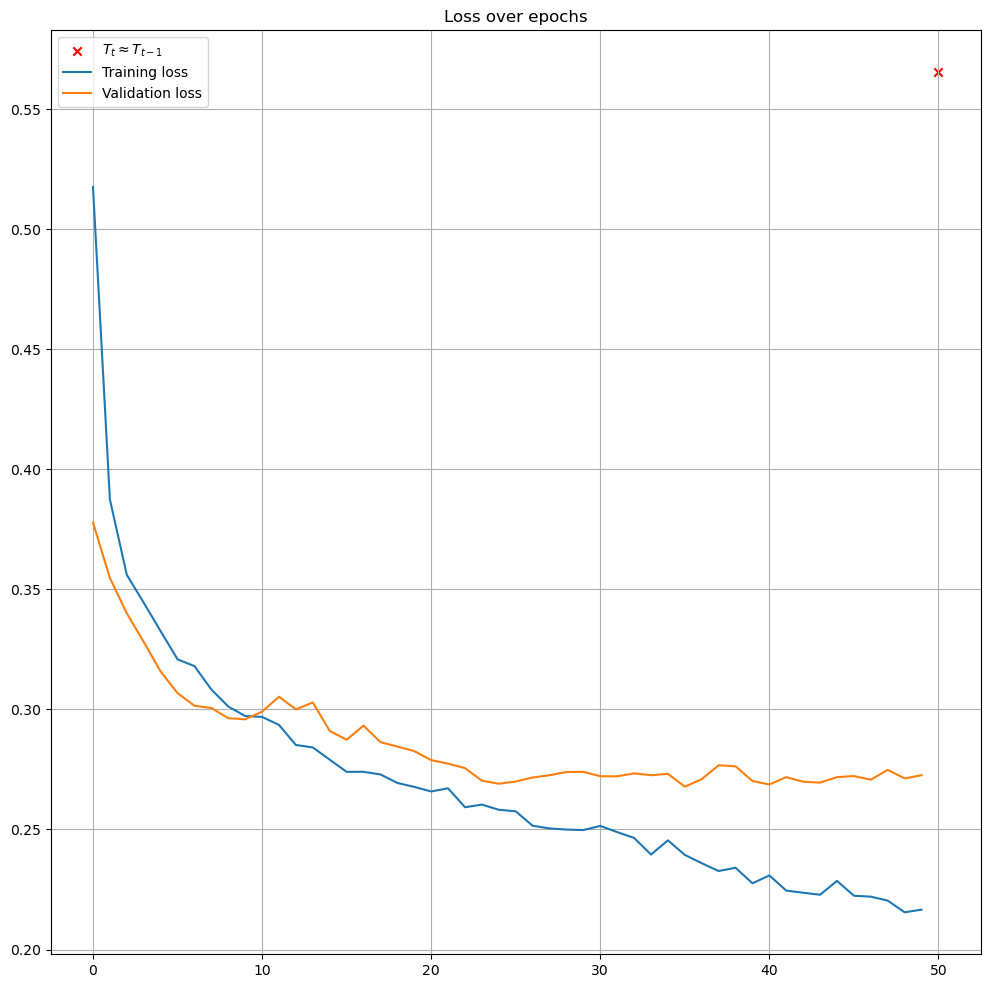

In [13]:
rnn.blocks[:-1].layer.configure(torch.nn.GRU)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

### Stacked LSTM

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 31.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(14, 32, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1-3): 3 x RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(32, 32, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (4): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


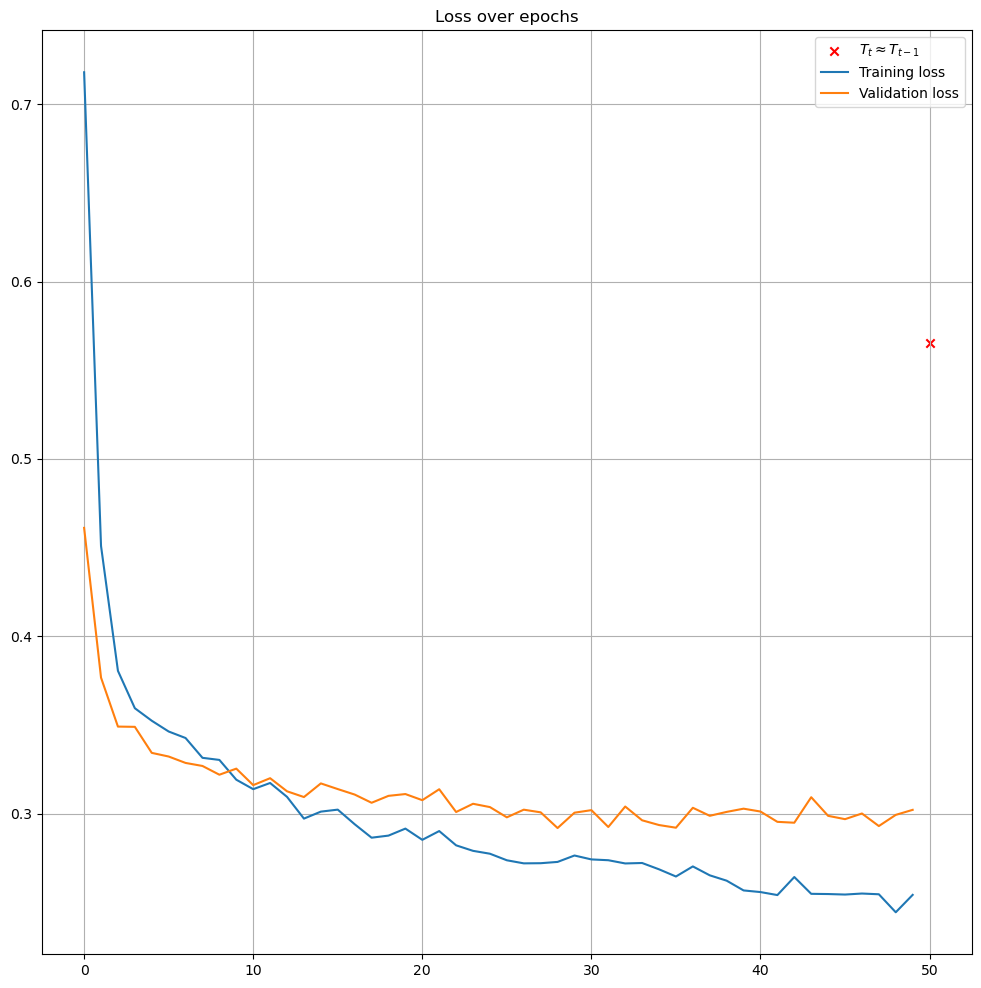

In [14]:
rnn.blocks[:-1].layer.configure(torch.nn.LSTM)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

### Introducing Dropout

We now introduce dropout to prevent overfitting.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 31.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(14, 32, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1-3): 3 x RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(32, 32, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (4): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


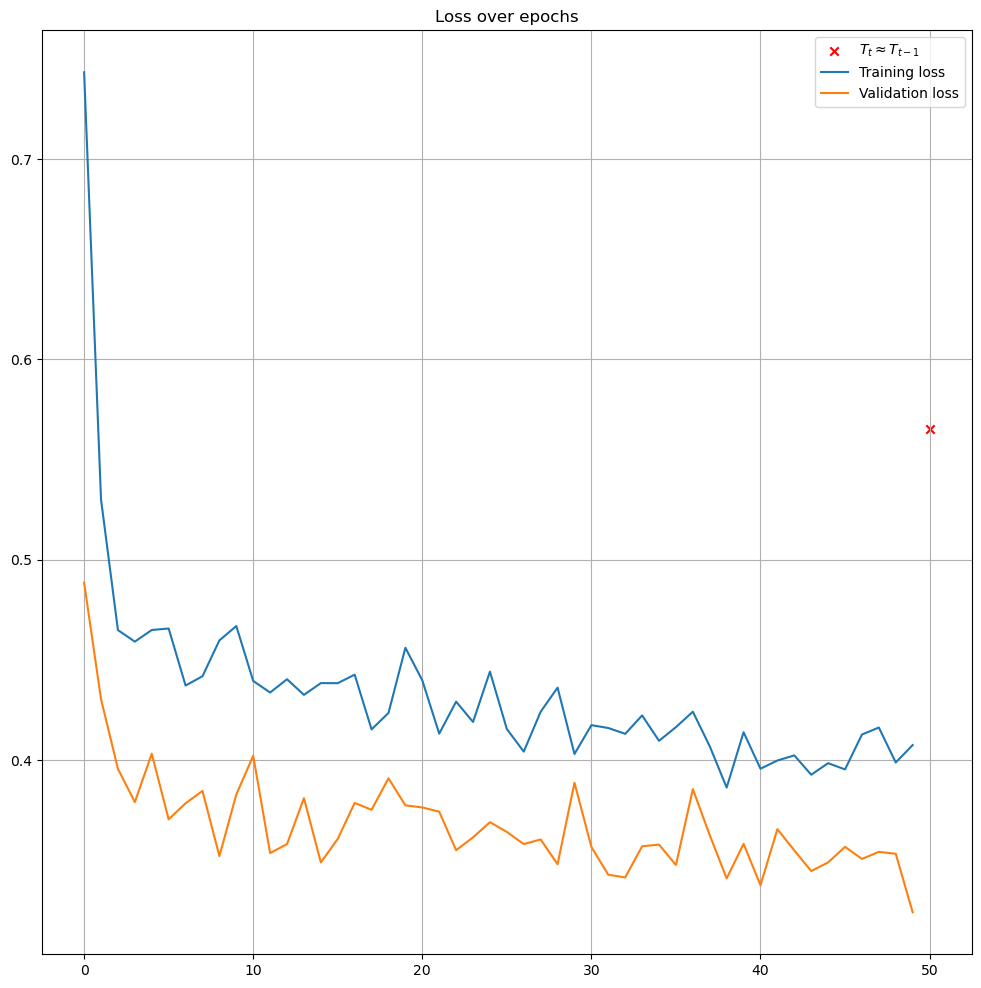

In [15]:

rnn.blocks.dropout.configure(p=0.2)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=50, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

## Implementing a Preprocessor

We now introduce a dense preprocessor in feature space.

In [17]:
hidden_size=32
hidden_features=[hidden_size]*4
dense_features=[hidden_size]*2

dense_preprocessor = dl.MultiLayerPerceptron(in_features=None,hidden_features=dense_features,out_features=hidden_features[0])
dense_preprocessor.dropout.configure(p=0.2)

rnn=dl.RNN(in_features=hidden_features[0],hidden_features=hidden_features,out_features=1,dropout=0.2,rnn_type="LSTM")

# Custom Reshape Layer
class Reshape(nn.Module):
    def __init__(self, new_shape):
        super(Reshape, self).__init__()
        self.new_shape = new_shape

    def forward(self, x):
        return x.view(self.new_shape)
    
dense_rnn = dl.Sequential(torch.nn.Flatten(start_dim=0,end_dim=1),dense_preprocessor,Reshape((-1, pred_window,hidden_features[-1])),rnn)
   
model = dl.Regressor(dense_rnn) 
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=50, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 35.9 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): Sequential(
    (0): Flatten(start_dim=0, end_dim=1)
    (1): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout(
          (layer): LazyLinear(in_features=0, out_features=32, bias=True)
          (activation): ReLU()
          (normalization): Identity()
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (1): LayerActivationNormalizationDropout(
          (layer): Linear(in_features=32, out_features=32, bias=True)
          (activation): ReLU()
          (normalization): Identity()
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (2): LayerActivationNormalizationDropout(
          (layer): Linear(in_features=32, out_features=32, bias=True)
          (activation): Identity()
          (normalizati

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]